# Tensor Pipeline

This note book runs the  lsr structured tensor ridge regression model with the following parameters fixed.

1. Ridge regression coefficient: 
2. Max iterations
3. Separation Rank
4. Tucker Rank



## Install Libraries

In [1]:
%pip install dill

Note: you may need to restart the kernel to use updated packages.


## System Path

In [2]:
import sys
import platform

# Check the operating system
if platform.system() == "Windows":
    # Using double backslashes
    sys.path.append(r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Closed_Form_Solver\Code Files")
elif platform.system() == "Darwin":  # macOS
    # Append path for macOS
    sys.path.append("Your path for macOS")

## Import Libraries

In [3]:
#Import sklearn stuff
import datetime
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy
from sklearn.metrics import r2_score 
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#Used to load data from pkl file
import dill

#Import External Files
from KFoldCV import KFoldCV
from train_test import train_test
from DataGenerationB import *

## Import Data

In [4]:
import platform
import numpy as np

if platform.system() == "Windows": 
    file_path = r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\fmri_rs.npy"
elif platform.system() == "Darwin":
    file_path = r"../Data/fmri_rs.npy"  # Adjust the path for macOS

with open(file_path, "rb") as f:
    fmri_rs = np.load(f)

# Each sample is a row
fmri_rs = fmri_rs.T


# Determine the platform and load the appropriate file
if platform.system() == "Windows": 
    mat_file_path = r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\MMP_HCP_60_splits.mat"
elif platform.system() == "Darwin":
    mat_file_path = "../Data/MMP_HCP_60_splits.mat"
else:
    raise ValueError("Unsupported platform")

# Load the .mat file
mat_file = scipy.io.loadmat(mat_file_path)

# Extract subject lists from the loaded file
seed_1 = mat_file['folds']['seed_1'][0, 0]
subject_lists = seed_1['sub_fold'][0, 0]['subject_list']
test_subjects = [int(item[0]) for item in subject_lists[0, 0].flatten()]

#Getting the HCP test subjects 

#array to hold the  subjects
HCP_753_Subjects = []
#file path
file_path = ''
#setting the file path
if platform.system() == "Windows":
    file_path = r'D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\MMP_HCP_753_subs.txt'
elif platform.system() == "Darwin":
    file_path = '../Data/MMP_HCP_753_subs.txt'
#if file pat  h is returned then load
if file_path:
    try:
        with open(file_path, 'r') as file:
            HCP_753_Subjects = [int(line.strip()) for line in file.readlines()]
    except Exception as e:
        print(f"An error occurred: {e}")


#Put the HCP test subjects into a dataframe
# Determine the platform and load the appropriate file
if platform.system() == "Windows":
    csv_file_path = r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\MMP_HCP_componentscores.csv"
elif platform.system() == "Darwin":
    csv_file_path = "../Data/MMP_HCP_componentscores.csv"

df = pd.read_csv(csv_file_path)
df['Subject'] = pd.to_numeric(df['Subject'], errors='coerce')
df = df[df['Subject'].isin(HCP_753_Subjects)].reset_index(drop = True)

#Split all our data into a Train and Test Set
df_train, df_test = df[~df['Subject'].isin(test_subjects)], df[df['Subject'].isin(test_subjects)]


In [5]:
#Create train and test arrays
train_subjects = df_train.index.to_list()
test_subjects = df_test.index.to_list()

#Reshape labels into column vector
X_train_vec, Y_train = fmri_rs[train_subjects], df_train["varimax_cog"].to_numpy().reshape((-1, 1))
X_test_vec, Y_test = fmri_rs[test_subjects], df_test["varimax_cog"].to_numpy().reshape((-1, 1))

## Conversion: FC-Vectors --> FC Matrices

In [6]:
#conversion of the HCP data from Vector --> Matrix

def vectomat_matlab(vector, outputdim):
    '''
    This code is to regenerate the symmetric functional connectivity matrix from the given vectorized upper triangular portion.
    This code accounts for the mismatch between MATLAB and Python indexing.

    vector: ndarray - the sample vector as a column vector (:,1)
    outputdim: scalar - the dimension of the symmetric matrix
    '''

    # Checking whether the vector dimension and the desired output dimensions match
    vector_length = vector.shape[0]
    desired_length = outputdim * (outputdim - 1) / 2

    # Check if lengths match and raise an error if not
    if vector_length != desired_length:
        raise ValueError("Vector length is insufficient to construct the symmetric matrix.")
    
    # Create a symmetric matrix with zeros
    matrix = np.zeros((outputdim, outputdim))
    
    p = 0
    
    for i in range(outputdim):
        for j in range (i,outputdim):
            if i == j :
                matrix[i,j] = 1
            else:
                matrix[i,j] = vector[p]
                matrix[j,i] = matrix[i,j]
                p = p+1
                
    return matrix

def samplestomat(dataset,outputdim):
    
    '''
    This code is developed to convert the vectorized data matrix in to a 3D data tensor.
    
    dataset : nd:array - (samples*features)
    outputdim : scalar

    '''

    #number of samples
    n_samples = dataset.shape[0]
    #3D matrix to hold the output
    out_dataset = np.zeros((n_samples,outputdim,outputdim))

    for p in range(n_samples):
        
        sample = dataset[p]
        sample = vectomat_matlab(sample,outputdim)
        out_dataset[p] = sample

    random_index = np.random.randint(0, n_samples)
    random_sample = out_dataset[random_index]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(random_sample, cmap='viridis', cbar=True)
    plt.title(f'Heatmap of Random Sample {random_index}')
    plt.show()

    return out_dataset
        




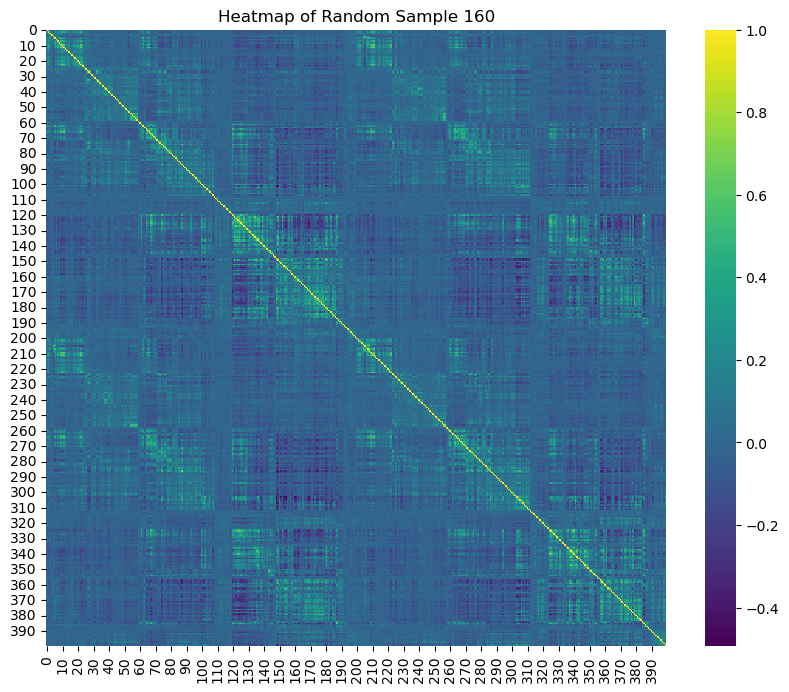

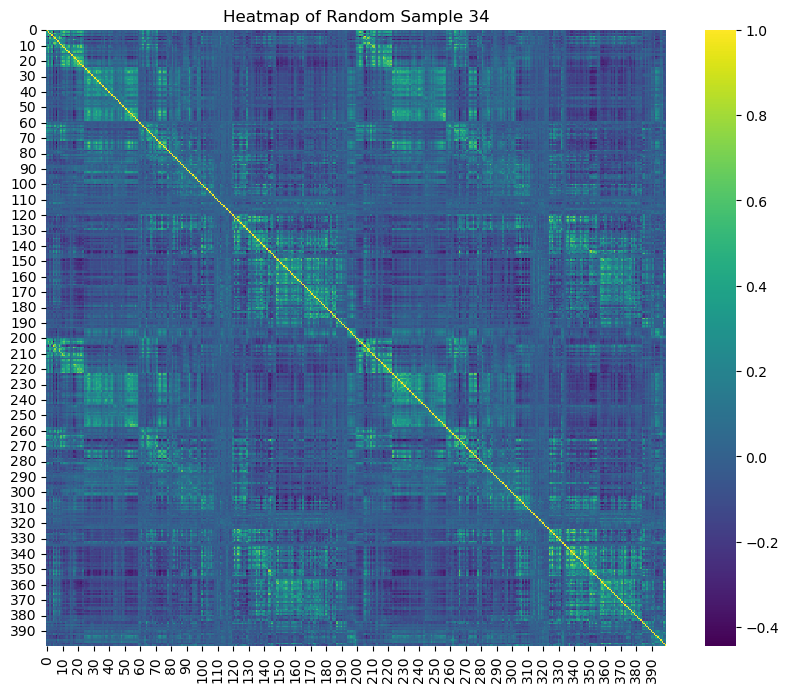

(677, 400, 400)
(677,)
(76, 400, 400)
(76,)


In [7]:
#Training data
X_train = samplestomat(X_train_vec,400)
X_test  = samplestomat(X_test_vec,400)
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)


print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


##  Preprocessing 

### Cosine Similarity



In [8]:
#Function to row wise normalization of samples

def normalize_rows(matrix):
    """
    Normalize each row of the given matrix by the norm of the row.
    
    Parameters:
    matrix (numpy.ndarray): The input matrix to be normalized.
    
    Returns:
    numpy.ndarray: The row-normalized matrix.
    """
    # Calculate the L2 norm for each row. Adding a small epsilon to avoid division by zero.
    row_norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    epsilon = 1e-10  # Small value to prevent division by zero
    row_norms[row_norms == 0] = epsilon
    
    # Normalize each row by its norm
    normalized_matrix = matrix / row_norms
    
    return normalized_matrix

#Reassign

X_train = normalize_rows(X_train)
X_test = normalize_rows(X_test)


### Removing intercept

In [9]:
#number of samples in train and test 
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# Reshape the 3D array to a 2D array where each row represents a sample
# The shape of the original 3D array is (n_samples, n_features_per_sample, n_dimensions)
# We reshape it to (n_samples, n_features_per_sample * n_dimensions)

X_train_2D = X_train.reshape(n_train, -1)
X_test_2D = X_test.reshape(n_test,-1)

# Initialize StandardScaler
scaler = StandardScaler(with_std = False) #standard scalar only

# Fit scaler on train data and transform train data
X_train_scaled = scaler.fit_transform(X_train_2D)
# Transform test data using the scaler fitted on train data
X_test_scaled = scaler.transform(X_test_2D)

# Reshape the scaled data back to 3D
X_train = X_train_scaled.reshape(n_train, X_train.shape[1],X_train.shape[2])
X_test  = X_test_scaled.reshape(n_test, X_test.shape[1],X_train.shape[2])

#average response value
Y_train_mean = np.mean(Y_train)
# Mean centering y_train and y_test
Y_train = Y_train - Y_train_mean


print("Sample mean for each feature (across samples):",scaler.mean_)
print("Sample variance for each feature (across samples):",scaler.var_)
print('Response Average:',Y_train_mean)




Sample mean for each feature (across samples): [0.41357128 0.10264033 0.12809567 ... 0.08301964 0.1107928  0.40418765]
Sample variance for each feature (across samples): None
Response Average: 1.127096656182391


## Hyper Parameters

In [10]:
tensor_dimensions = np.array([X_train.shape[1], X_train.shape[2]])
tensor_mode_ranks = np.array([25, 25])
separation_rank = 2

#For now, define finite alpha set that we are searching over
alphas = [0,0.5,1,10,20,30,40,50,100,150,180]
#0,0.5,1,10,20,30,40,50,100,150,180
#searching around 180
#176,178,180,182,184



## KFoldCV if we nee to run KFold cross validation 

In [11]:
#Define Number of Folds we want
k_folds = 5
hypers = {'max_iter': 50, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank}
lambda1, validation_normalized_estimation_error, validation_nmse_losses, validation_correlations, validation_R2_scores, objective_function_information,gradient_information = KFoldCV(X_train, Y_train, alphas, k_folds, hypers, B_tensored = None, intercept= False)

intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is n

c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 0, Alpha = 180, NMSE: 1.0, Correlation: nan, R^2 Score: -0.0018910088903176803


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold = 1, Alpha = 0, NMSE: 1334.5891371297405, Correlation: 0.02136424427947927, R^2 Score: -1335.3401341511449
Fold = 1, Alpha = 0.5, NMSE: 41.69295137128653, Correlation: 0.12791429775806562, R^2 Score: -40.74765302562615
Fold = 1, Alpha = 1, NMSE: 9.981083431985926, Correlation: 0.008899804460163347, R^2 Score: -8.994178733658606
Fold = 1, Alpha = 10, NMSE: 1.389393665444553, Correlation: 0.30225247791258586, R^2 Score: -0.39121656666715965
Fold = 1, Alpha = 20, NMSE: 1.2234183384091377, Correlation: 0.3314138183006955, R^2 Score: -0.2250234780037046
Fold = 1, Alpha = 30, NMSE: 0.9473107205280019, Correlation: 0.4043594299484964, R^2 Score: 0.05144639639746906
Fold = 1, Alpha = 40, NMSE: 0.9622494565771391, Correlation: 0.3862964973806837, R^2 Score: 0.036488060546716494
Fold = 1, Alpha = 50, NMSE: 0.9948801843122177, Correlation: 0.3567845005928932, R^2 Score: 0.0038145209038524808
Fold = 1, Alpha = 100, NMSE: 0.883801559915434, Correlation: 0.3769018602969143, R^2 Score: 0.1150388

c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold = 2, Alpha = 0, NMSE: 2620.0500347242705, Correlation: -0.0292130232946971, R^2 Score: -2619.0509354485666
Fold = 2, Alpha = 0.5, NMSE: 27.004878664249652, Correlation: 0.12459755040484696, R^2 Score: -26.004887948022866
Fold = 2, Alpha = 1, NMSE: 22.707134842362173, Correlation: 0.06640022340869965, R^2 Score: -21.70714264865128
Fold = 2, Alpha = 10, NMSE: 1.1729038294623835, Correlation: 0.3331068910292025, R^2 Score: -0.1729042326848267
Fold = 2, Alpha = 20, NMSE: 1.1243890350893422, Correlation: 0.40987428158209194, R^2 Score: -0.12438942163330458
Fold = 2, Alpha = 30, NMSE: 0.9460244938535975, Correlation: 0.42446084578417526, R^2 Score: 0.05397518092083986
Fold = 2, Alpha = 40, NMSE: 0.91739268096044, Correlation: 0.4600380431480634, R^2 Score: 0.08260700365708029
Fold = 2, Alpha = 50, NMSE: 0.914458919894218, Correlation: 0.43410400233518914, R^2 Score: 0.08554076573187452


LinAlgError: SVD did not converge

## Train + Test Block

In [ ]:
hypers = {'max_iter': 50, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank}
test_normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values,iterate_level_values,iterate_level_reconstructed_tensor = train_test(X_train, Y_train, X_test, Y_test, lambda1, hypers,Y_train_mean, B_tensored = None, intercept= False)

intercept is not initialized
Y_test_predicted: [ 0.85893682  1.39737946 -0.55395314 -1.39445935 -0.48265396  0.02694469
  0.23083781  2.35066681  1.2940993  -0.12221383  0.64868786  0.60387313
  0.31276454  2.13067795  0.10207682  2.74241416  2.00747206  1.35477615
  0.22654893  1.44669158  1.95011841  2.0910597   0.16861635  0.53451998
  0.8450319   1.43301614  0.95037245  0.55847981  2.13553235  2.45213125
  1.47909521  0.33882732  0.19923005  1.41487025  0.85694816  1.81023699
  0.15913716  0.86414923  1.22008254 -0.89377149 -0.02612901  1.01039592
  1.71030581 -1.17413843  0.87815464  2.33170968  0.77870668  2.5161329
  0.41878345  2.49842197  2.79034539  0.34207308  1.70114624 -2.19653877
  1.16201138  1.3237068   0.92838276  0.48555717 -0.19937768  0.96498946
  2.12554687  0.07081294  2.96669365  2.87082346  1.24279623  2.39975146
  1.38559559  1.50697043  1.27470597 -0.48607903 -0.45003759  0.51543362
  1.54000572 -0.78127011 -0.23687354 -0.54656844], Y_test: [ 1.49770661  1.924

## Save Results

In [ ]:
#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
max_iter = hypers['max_iter']

if platform.system() == "Windows":
    pkl_file = rf"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression_All_Data\Closed_Form_Solver\LSR\Separation Rank 2\Normalize_Int_Removal\Row wise Normalization\HCP_lambdas_{alphas}_sep_{separation_rank}_tucker_{tensor_mode_ranks}.pkl"
elif platform.system() == "Darwin":
    pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Stochastic LSR TRR/Experimental Results/ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"


In [ ]:
print("Error Record on Training _ After K-Fold CV")
print("Validation Normalized Estimation Error: ", validation_normalized_estimation_error)
print("Validation NMSE Losses: ", validation_nmse_losses)
print("Validation Correlations: ", validation_correlations)
print("Validation R2 Scores: ", validation_R2_scores)

Error Record on Training _ After K-Fold CV
Validation Normalized Estimation Error:  inf
Validation NMSE Losses:  [[9.01201316e+02 1.65805496e+02 5.26670873e+01 1.06861057e+00
  1.24016093e+00 8.94764569e-01 8.54439115e-01 9.68148572e-01
  7.72324223e-01 7.58463786e-01 1.00000000e+00]
 [1.00033766e+03 1.38379649e+02 7.68307381e+01 1.24649894e+00
  9.33448546e-01 1.01967955e+00 8.55993165e-01 7.12739894e-01
  7.39309083e-01 7.85948518e-01 8.62345070e-01]
 [5.16748969e+02 1.30150795e+02 5.54464247e+01 8.23052794e-01
  8.01491405e-01 7.32111294e-01 8.61646348e-01 8.69834465e-01
  7.46047948e-01 7.93039705e-01 1.00000000e+00]
 [1.28761075e+03 3.18039326e+02 1.25434004e+02 1.25983467e+00
  1.16015315e+00 1.14270913e+00 1.00253450e+00 1.01142317e+00
  8.18418613e-01 7.56395507e-01 1.00000000e+00]
 [7.74800133e+02 1.26122260e+02 6.54998406e+01 1.16300670e+00
  1.25801991e+00 1.07731780e+00 8.77582032e-01 1.00970411e+00
  7.58061610e-01 8.15088973e-01 1.00000000e+00]]
Validation Correlations:  

In [ ]:
print("Error Report on Testing _ With best Lambda")
print("Alpha chosen for model: ", lambda1)
print("Test Normalized Estimation Error: ", test_normalized_estimation_error)
print("Test NMSE Loss: ", test_nmse_loss)
print("Test R2 Loss: ", test_R2_loss)
print("Test Correlation: ", test_correlation)

Error Report on Testing _ With best Lambda
Alpha chosen for model:  100
Test Normalized Estimation Error:  inf
Test NMSE Loss:  0.8563457583375267
Test R2 Loss:  0.08194173399820504
Test Correlation:  0.3631198113544962


In [ ]:
with open(pkl_file, "wb") as file:
    dill.dump((X_train,Y_train,X_test,Y_test, lambda1, validation_normalized_estimation_error, validation_nmse_losses, validation_correlations, validation_R2_scores, objective_function_information,gradient_information,test_normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values,iterate_level_values,iterate_level_reconstructed_tensor), file)
    

In [ ]:
print(validation_correlations)

[[ 0.29747842  0.04532605  0.17329752  0.45681012  0.34993864  0.48121877
   0.5049374   0.38798977  0.48344854  0.50337132         nan]
 [ 0.03438863  0.10358999  0.01895828  0.37090227  0.41876921  0.42017485
   0.43672424  0.54821235  0.51664812  0.4946124   0.44445102]
 [ 0.18963614  0.04727076  0.10449898  0.55364834  0.51542251  0.54620308
   0.45562323  0.43230833  0.49653234  0.47388392         nan]
 [ 0.16135563 -0.06600129  0.01751371  0.33683325  0.32986998  0.36369584
   0.37865479  0.39310072  0.42241777  0.49416666         nan]
 [-0.0644579   0.02133784  0.11742112  0.34553282  0.34319969  0.3699438
   0.46193728  0.33265322  0.49661259  0.43725586         nan]]
